### Setup
First, load the model.

In [1]:
from modeling_gpt2 import GPT2Model, GPT2LMHeadModel
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2", cache_dir="hf_home/")
# model = GPT2Model.from_pretrained("gpt2", cache_dir="hf_home/")  # for forward pass
model = GPT2LMHeadModel.from_pretrained("gpt2", cache_dir="hf_home/")  # for generation
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### Initial Testing for Correctness
Now, let's do forward passes on some sample inputs. Starting with the baseline.

In [2]:
# NOTE: For some reason if I run this first it will mess up future runs with illegal access errors.
# inputs = tokenizer(["Today is"], return_tensors="pt").to('cuda')
# model.transformer.config._attn_implementation = "sdpa"  # NOTE: This is default, but we set manually here for emphasis.
# out = model.forward(inputs['input_ids'])
# out.logits

tensor([[[ -36.3292,  -36.3402,  -40.4228,  ...,  -46.0234,  -44.5284,
           -37.1276],
         [-122.8355, -122.5403, -127.6362,  ..., -133.4906, -131.9769,
          -125.4615]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)

Now, using the minimal-flash-attn default attention implementation. Default is `sdpa`.

In [2]:
import os
import torch.multiprocessing as mp
mp.set_start_method('spawn')

In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
inputs = tokenizer(["Today is"], return_tensors="pt").to('cuda')
model.transformer.config._attn_implementation = "mha_forward"
out = model.forward(inputs['input_ids'])
out.logits

tensor([[[-46.1493, -41.3502, -46.9205,  ..., -51.2624, -51.9450, -45.0349],
         [ -7.1730,  -7.7093,  -9.9565,  ..., -15.9324, -15.7373,  -7.7972]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)

*Note*: These logits are different -- there's likely some problem with the gpu memory. If I run this multiple times, gpu memory goes up without getting cleaned up.

Now using our improved version.

In [6]:
inputs = tokenizer(["Today is"], return_tensors="pt").to('cuda')
model.transformer.config._attn_implementation = "improved_mha_forward"
out = model.forward(inputs['input_ids'])
out.logits

tensor([[[-200.5994, -194.6887, -200.0166,  ..., -219.0208, -221.8667,
          -200.6157],
         [   1.8309,    2.3841,   -3.6275,  ...,   -3.0478,   -5.7368,
             1.4115]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)

### Initial Testing for Timing
Great! We can see the shapes are the same and the output tensors are too. This means the attention implementation is correct. Now, let's see if it is faster.

In [9]:
import os
os.makedirs("traces", exist_ok=True)

In [48]:
import torch
import time
attn_implementations = ["sdpa", "mha_forward", "improved_mha_forward"]
for attn_implementation in attn_implementations:
    print(f'=== profiling `{attn_implementation}` attention === ')
    model.transformer.config._attn_implementation = attn_implementation
    with torch.autograd.profiler.profile(use_device='cuda') as prof:
        start_time = time.time()
        out = model.forward(inputs['input_ids'])
        end_time = time.time()
    prof.export_chrome_trace(f"traces/{attn_implementation}_trace.json")  # note we can inspect these with chrome://tracing/
    print(prof.key_averages().table(sort_by='cuda_time_total', row_limit=10))
    print(f"Total time taken: {end_time - start_time}\n\n")

=== profiling `sdpa` attention === 
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      aten::addmm        11.60%       3.083ms        17.52%       4.659ms      97.066us       4.360ms        16.05%       5.354ms     111.542us            48  
                                 aten::layer_norm         0.97%     258.963us        13.13%       3.491ms     139.639us     391.000us         1.44%       3.624ms     144.960us            25  
   

Note we see that the default minimal flash attn implementation is faster by ~7ms! And we can see the `aten::scaled_dot_product_attention` runs for the baseline and our `minimal_attn::mha_forward kernel` replaces it, as desired. For now, it does appear to take slightly more CUDA time, which makes sense as we have to use more memory -- the original version probably has more to do on the CPU. In the future we will test how that varies with different input sizes.

| Name                                     | Self CPU %   | Self CPU    | CPU total % | CPU total   | CPU time avg | Self CUDA   | Self CUDA % | CUDA total  | CUDA time avg | # of Calls |
| :--------------------------------------- | :----------- | :---------- | :---------- | :---------- | :----------- | :---------- | :---------- | :---------- | :------------ | :--------- |
| `aten::scaled_dot_product_attention`     | 0.67%        | 213.412us   | 9.23%       | 2.931ms     | 244.211us    | 302.000us   | 1.27%       | 2.978ms     | 248.167us     | 12         |
| `minimal_attn::mha_forward`              | 1.01%        | 162.292us   | 8.00%       | 1.285ms     | 107.096us    | 2.465ms     | 14.54%      | 3.323ms     | 276.917us     | 12         |

In [ ]:
# Create a bunch of inputs with random tokens.
# Note we are not doing real words bc we are not dealing with masking right now
# and there should be no need.


### Generation
Let's try generation now before starting the benchmarking.

In [7]:
# Generate text
import torch
import time

def generate_and_decode(model, inputs, max_new_tokens=128, verbose=True):
    with torch.no_grad():
        output_ids = model.generate(
            inputs,
            attention_mask=torch.ones_like(inputs),  # need else errors
            max_new_tokens=max_new_tokens,
            num_return_sequences=1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id  # need else errors
        )
        if verbose:
            print(tokenizer.decode(output_ids[0]))

def run_with_tracing(inputs, attn_implementation):
    print(f'=== profiling `{attn_implementation}` attention === ')
    model.transformer.config._attn_implementation = attn_implementation
    with torch.autograd.profiler.profile(use_device='cuda') as prof:
        start_time = time.time()
        out = generate_and_decode(model, inputs)
        end_time = time.time()
    # prof.export_chrome_trace(f"traces/{attn_implementation}_generation_trace.json")  # note we can inspect these with chrome://tracing/
    print(prof.key_averages().table(sort_by='cuda_time_total', row_limit=10))
    total_time_taken = end_time - start_time
    print(f"Total time taken: {total_time_taken}\n\n")
    return total_time_taken

def run_with_no_profiling(inputs, attn_implementation):
    model.transformer.config._attn_implementation = attn_implementation
    start_time = time.time()
    out = generate_and_decode(model, inputs, verbose=False)
    end_time = time.time()
    total_time_taken = end_time - start_time
    return total_time_taken

In [50]:
inputs = tokenizer(["Today is"], return_tensors="pt").to('cuda')['input_ids']
attn_implementations = ["sdpa", "mha_forward", "improved_mha_forward"]
for attn_implementation in attn_implementations:
    run_with_tracing(inputs, attn_implementation)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


=== profiling `sdpa` attention === 
Today is the day when we can all be proud of our country and our values.

We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We are all Americans. We


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::addmm        12.19%     286.732ms        17.92%     421.569ms      68.615us     454.704ms        18.63%     520.811ms      84.767us          6144  
                                       aten::layer_norm         1.25%      29.432ms        14.24%     334.956ms     104.674us      41.985ms         1.72%     347.771ms     108.678us          3200  
         

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::addmm        11.03%     283.248ms        16.18%     415.595ms      67.642us     451.696ms        17.30%     515.212ms      83.856us          6144  
                              minimal_attn::mha_forward         2.67%      68.467ms        18.28%     469.451ms     305.632us      85.976ms         3.29%     479.331ms     312.064us          1536  
         

### Benchmarking
For our full results, we will benchmark across a grid of experiments.

Note that the GPT-2 context window is 1024 tokens, so the full input tokens + output tokens requested must reasonably sum to that.

For performance, our sole focus is on speed, since Flash Attention results in the same output as attention so we cannot improve scores on language benchmarks.

Hence our input will be all random tokens of various sizes, as the model itself doesn't see any difference between random tokens and sensible input.

Our grid will be as follows:

input sizes: [64, 128, 256, 512]

max new tokens: [64, 128, 256, 512]

We will run every combination on three methods: the original model, Minimal Flash Attention, and our Improved Minimal Flash Attention.

In [3]:
tokenizer

GPT2Tokenizer(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [5]:
tokenizer(["Today is"], return_tensors="pt").to('cuda')

{'input_ids': tensor([[8888,  318]], device='cuda:0'), 'attention_mask': tensor([[1, 1]], device='cuda:0')}

In [8]:
import random

inp_sizes = [16, 32, 64, 128]  # , 256, 512]
all_max_new_tokens = inp_sizes

times = {}  # { attn_implementation: { input_output: [list of time taken] } }
num_iterations = 5  # number of runs per attn_implementation, inp_size, max_new_tokens tuple
batch_size = 16

attn_implementations = ["sdpa", "mha_forward", "improved_mha_forward"]
for attn_implementation in attn_implementations:
    for inp_size in inp_sizes:
        for max_new_tokens in all_max_new_tokens:
            print(f"Attn: {attn_implementation} with Seq Len {inp_size}, Max New Tokens {max_new_tokens}")
            for _ in range(num_iterations):
                inputs = []
                # Create random input
                for _ in range(batch_size):
                    input_tokens = []
                    for _ in range(inp_size):
                        input_tokens.append(random.randint(0, tokenizer.vocab_size - 1))
                    input_tensor = torch.tensor(input_tokens, dtype=torch.int64).unsqueeze(0).to('cuda')  # unsqueeze since batch size is 1
                    inputs.append(input_tensor)
                inputs = torch.concatenate(inputs)
                print(inputs.shape)

                # Run
                total_time_taken = run_with_no_profiling(inputs, attn_implementation)
                print(f"\t{total_time_taken}s")

                # Store list of times
                key = f'{inp_size}_{max_new_tokens}'
                if attn_implementation not in times:
                    times[attn_implementation] = {}
                if key not in times[attn_implementation]:
                    times[attn_implementation][key] = []
                times[attn_implementation][key].append(total_time_taken)
        

Attn: sdpa with Seq Len 16, Max New Tokens 16
torch.Size([16, 16])
	1.5787739753723145s
torch.Size([16, 16])
	1.5021450519561768s
torch.Size([16, 16])
	1.5115647315979004s
torch.Size([16, 16])
	1.5007071495056152s
torch.Size([16, 16])
	1.5019419193267822s
Attn: sdpa with Seq Len 16, Max New Tokens 32
torch.Size([16, 16])
	1.4979779720306396s
torch.Size([16, 16])
	1.4992895126342773s
torch.Size([16, 16])
	1.4991469383239746s
torch.Size([16, 16])
	1.5077416896820068s
torch.Size([16, 16])
	1.4963452816009521s
Attn: sdpa with Seq Len 16, Max New Tokens 64
torch.Size([16, 16])
	1.49678373336792s
torch.Size([16, 16])
	1.5173814296722412s
torch.Size([16, 16])
	1.501009464263916s
torch.Size([16, 16])
	1.5003688335418701s
torch.Size([16, 16])
	1.4974079132080078s
Attn: sdpa with Seq Len 16, Max New Tokens 128
torch.Size([16, 16])
	1.503227949142456s
torch.Size([16, 16])
	1.500542402267456s
torch.Size([16, 16])
	1.5292694568634033s
torch.Size([16, 16])
	1.5047986507415771s
torch.Size([16, 16])
	

Now we'll get summary statistics as well as a graph.

In [12]:
# Save times dict so no need to rerun.
import pickle
with open("times_dict.pkl", "wb") as f:
    pickle.dump(times, f)

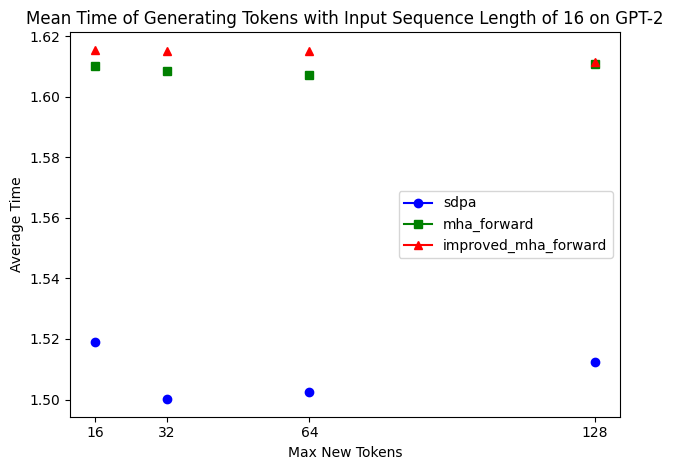

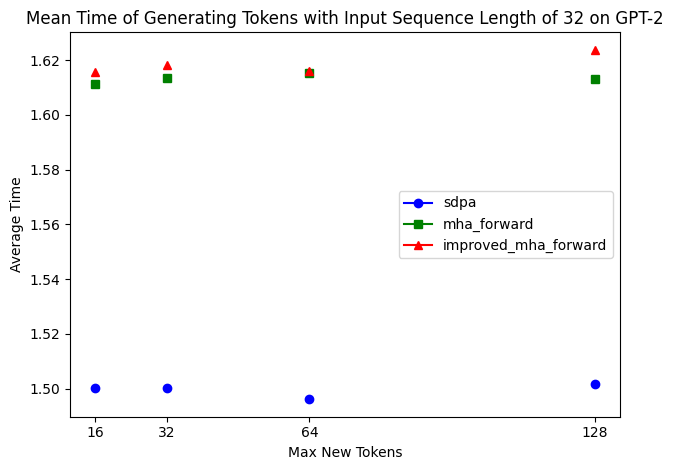

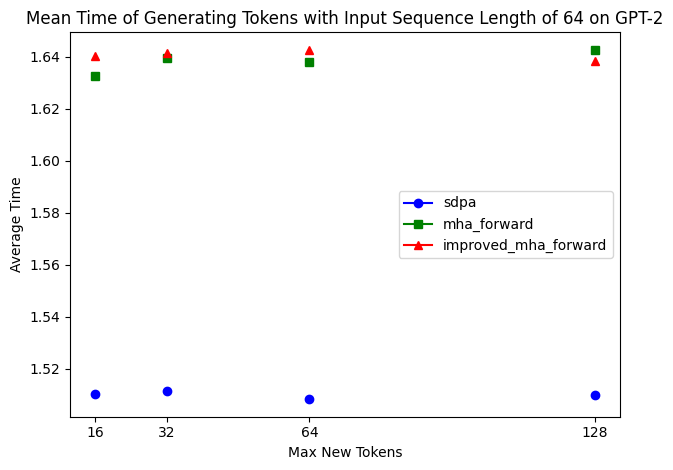

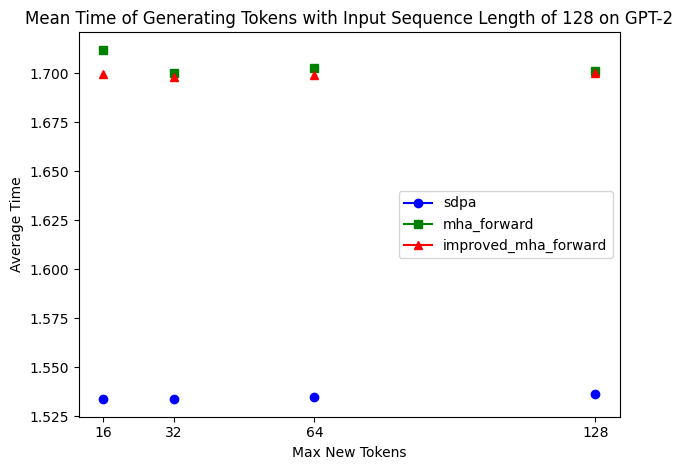

In [44]:
import matplotlib.pyplot as plt
means = []
figs = []
axs = []
plotted_labels = []
markers = {
    attn_implementations[i]: ["o", "s", "^"][i]
    for i in range(len(attn_implementations))
}
colors = {
    'sdpa': 'blue',
    'mha_forward': 'green',
    'improved_mha_forward': 'red'
}
for inp_size in inp_sizes:
    fig, ax = plt.subplots()
    figs.append(fig)
    axs.append(ax)
    ax.set_xlabel("Max New Tokens")
    ax.set_ylabel("Average Time")
    ax.set_title(f"Mean Time of Generating Tokens with Input Sequence Length of {inp_size} on GPT-2")
    ax.set_xticks(all_max_new_tokens)
    for max_new_tokens in all_max_new_tokens:
        for attn_implementation in attn_implementations:
            key = f'{inp_size}_{max_new_tokens}'
            if attn_implementation not in times or key not in times[attn_implementation]:
                continue
            l = torch.Tensor(times[attn_implementation][key])
            mean = l.mean().item()
            median = l.median().item()
            minimum = l.min().item()
            maximum = l.max().item()
            stddev = l.std().item()
            label = attn_implementation if attn_implementation not in plotted_labels else None
            ax.plot(max_new_tokens, mean, marker=markers[attn_implementation], label=label, c=colors[attn_implementation])
            plotted_labels.append(label)
            # print("-" * 50)
            # print(f"Running {attn_implementation} on sequence length of {inp_size} with max new tokens of {max_new_tokens}:")
            # print(f"{mean=}, {median=}, {minimum=}, {maximum=}, {stddev=}")
for i in range(len(axs)):
    axs[i].legend(colors)
    figs[i].tight_layout()
    figs[i].savefig(f"figs/plot_{i}.png", dpi=300, bbox_inches='tight')
# figs[0].save()